# 2D Four-well potential

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from pydiffmap import diffusion_map as dm

%matplotlib inline

Load sampled data: discretized Langevin dynamics at temperature T=1, friction 1, and time step size dt=0.01, with double-well potentials in x and y, with higher barrier in y.

In [48]:
X=np.load('Data/4wells_traj.npy')
print(X.shape)

(9900, 2)


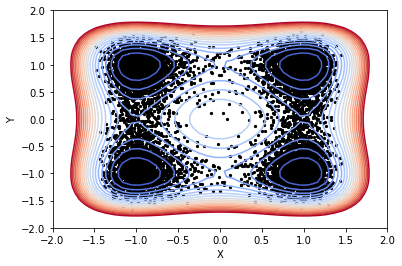

In [3]:
def DW1(x):
        return 2.0*(np.linalg.norm(x)**2-1.0)**2

def DW2(x):
        return 4.0*(np.linalg.norm(x)**2-1.0)**2

def DW(x):
    return DW1(x[0]) + DW1(x[1])

from matplotlib import cm

mx=5

xe=np.linspace(-mx, mx, 100)
ye=np.linspace(-mx, mx, 100)
energyContours=np.zeros((100, 100))
for i in range(0,len(xe)):
            for j in range(0,len(ye)):
                xtmp=np.array([xe[i], ye[j]] )
                energyContours[j,i]=DW(xtmp)

levels = np.arange(0, 10, 0.5)
plt.contour(xe, ye, energyContours, levels, cmap=cm.coolwarm)
plt.scatter(X[:,0], X[:,1], s=5, c='k')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()


## Compute diffusion map embedding

In [64]:
mydmap = dm.DiffusionMap(n_evecs = 2, epsilon = .2, alpha = 0.5, k=400, metric='euclidean')
dmap = mydmap.fit_transform(X)

## Visualization

We plot the first two diffusion coordinates against each other, colored by the x coordinate

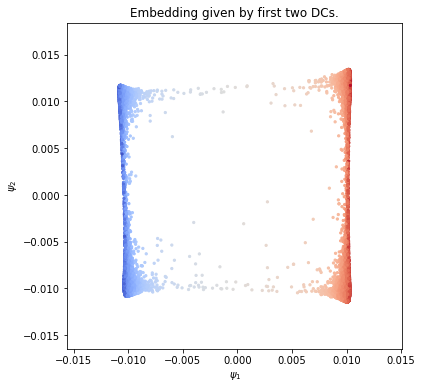

In [65]:
from pydiffmap.visualization import embedding_plot

embedding_plot(mydmap, scatter_kwargs = {'c': X[:,0], 's': 5, 'cmap': 'coolwarm'})

plt.show()

In [25]:
#from matplotlib import cm
#plt.scatter(dmap[:,0], dmap[:,1], c=X[:,0], s=5, cmap=cm.coolwarm)

#clb=plt.colorbar()
#clb.set_label('X coordinate')
#plt.xlabel('First dominant eigenvector')
#plt.ylabel('Second dominant eigenvector')
#plt.title('Diffusion Map Embedding')

#plt.show()

We visualize the data again, colored by the first eigenvector this time.

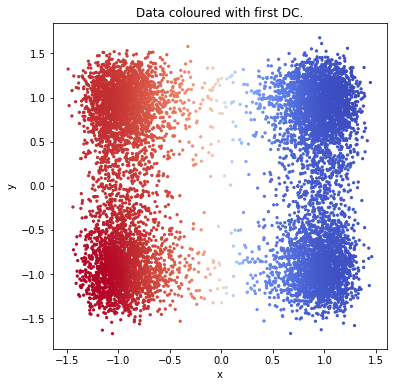

In [31]:
from pydiffmap.visualization import data_plot

data_plot(mydmap, scatter_kwargs = {'s': 5, 'cmap': 'coolwarm'})
plt.show()

## Target measure diffusion map

Compute Target Measure Diffusion Map with target distribution pi(q) = exp(-beta V(q)) with inverse temperature beta = 1. TMDmap can be seen as a special case where the weights are the target distribution, and alpha=1.

In [49]:
V=DW
beta=1
target_distribution=np.zeros(len(X))
for i in range(len(X)):
    target_distribution[i]=np.exp(-beta*V(X[i]))
mytdmap = dm.DiffusionMap(alpha=1.0, n_evecs = 2, epsilon = .2, k=400)
tmdmap = mytdmap.fit_transform(X, weights=target_distribution)

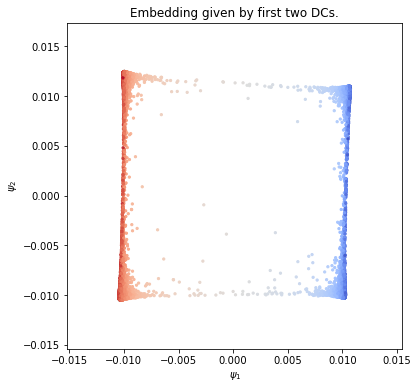

In [50]:
embedding_plot(mytdmap, scatter_kwargs = {'c': X[:,0], 's': 5, 'cmap': 'coolwarm'})

plt.show()

From the sampling at temperature 1/beta =1, we can compute diffusion map embedding at lower temperature T_low = 1/beta_low using TMDmap  with target measure pi(q) = exp(-beta_low V(q)). Here we set beta_low = 10, and use the data obtained from sampling at higher temperature, i.e. pi(q) = exp(-beta V(q)) with beta = 1. 

In [57]:
V=DW
beta=10
target_distribution2=np.zeros(len(X))
for i in range(len(X)):
    target_distribution2[i]=np.exp(-beta*V(X[i]))
mytdmap2 = dm.DiffusionMap( alpha = 1.0, n_evecs = 2, epsilon = .2,  k=400)
tmdmap2 = mytdmap2.fit_transform(X, weights=target_distribution2)

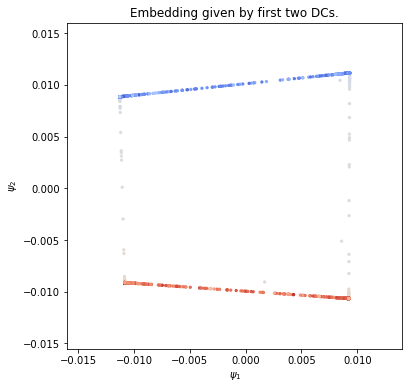

In [58]:
embedding_plot(mytdmap2, scatter_kwargs = {'c': X[:,0], 's': 5, 'cmap': 'coolwarm'})

plt.show()

## Kernel density estimate

We can compute kernel density estimate using kde used in the diffusion map computation.

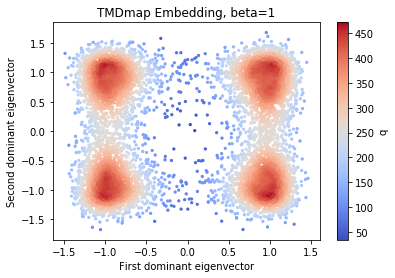

In [60]:
plt.scatter(X[:,0], X[:,1], c = mytdmap.q, s=5, cmap=cm.coolwarm)

clb=plt.colorbar()
clb.set_label('q')
plt.xlabel('First dominant eigenvector')
plt.ylabel('Second dominant eigenvector')
plt.title('TMDmap Embedding, beta=1')

plt.show()

Now we check how well we can approximate the target distribution by the formula in the paper (left dominant eigenvector times KDE).

In [61]:
import scipy.sparse.linalg as spsl
P = mytdmap.P
[evals, evecs] = spsl.eigs(P.transpose(),k=1, which='LM')

phi = np.real(evecs.ravel())

In [62]:
q_est = phi*mytdmap.q
q_est = q_est/sum(q_est)
q_exact = target_distribution/sum(target_distribution)
print(np.linalg.norm(q_est - q_exact,1))

0.0238580958123


visualize both. there is no visible difference.

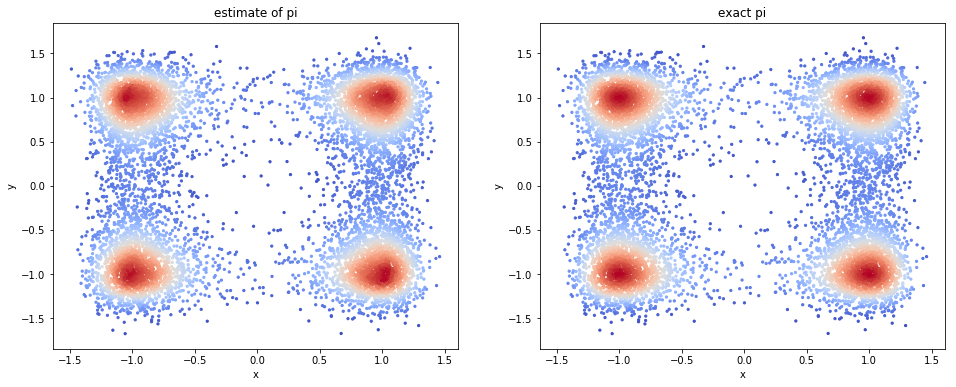

In [63]:
plt.figure(figsize=(16,6))

ax = plt.subplot(121)
ax.scatter(X[:,0], X[:,1], c = q_est, s=5, cmap=cm.coolwarm)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('estimate of pi')

ax2 = plt.subplot(122)
ax2.scatter(X[:,0], X[:,1], c = q_exact, s=5, cmap=cm.coolwarm)

ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('exact pi')

plt.show()